# 0.0: pull packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import joblib
import numpy as np
import random
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, model_selection, ensemble, svm, naive_bayes, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import getpass
import pyodbc
import sys
import sqlalchemy
import urllib
from datetime import date
from collections import Counter
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
import time
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import shap
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

## 0.1: read data

In [3]:
H10 = ['Pareto_Arizona','Pareto_Capital_V2_TEMP','Pareto_WHA','Pareto_HarvardPilgrim','Pareto_Red_BCBS_Idaho']
H09 = ['HealthDeterminantsDB']

In [4]:
for i in H10:
    if i == H10[0]:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL10;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_001_memberinfo')
        df_mem = pd.DataFrame(result.fetchall(),columns=result.keys())
    else:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL10;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_001_memberinfo')
        df_mem = df_mem.append(pd.DataFrame(result.fetchall(),columns=result.keys()))
        
        
for i in H09:
    if i == H09[0]:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL09;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_002_sdoh')
        df_sdoh = pd.DataFrame(result.fetchall(),columns=result.keys())
        

In [5]:
df_mem.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score
0,49,Pareto_Arizona,1,61,85255,MARICOPA,AZ,53593,DANE,WI,0,0.427
1,49,Pareto_Arizona,1,61,85255,MARICOPA,AZ,85602,COCHISE,AZ,0,0.427
2,74,Pareto_Arizona,0,22,85249,MARICOPA,AZ,19102,PHILADELPHIA,PA,1,0.380
3,74,Pareto_Arizona,0,22,85249,MARICOPA,AZ,89128,CLARK,NV,1,0.380
4,79,Pareto_Arizona,1,15,85142,MARICOPA,AZ,85637,SANTA CRUZ,AZ,0,0.101


In [27]:
c_maxes = df_mem.groupby(['memberRecKey', 'clientDB']).providerZip.transform(max)
df_mem = df_mem.loc[df_mem.providerZip == c_maxes]

In [28]:
df_sdoh.head()

,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP,county_name,state_abbrev,value,measure_type,sdoh_feature
0,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ABBEVILLE,SC,3,Estimate,Clinical Care Access to Care Dentists # Dentis...
1,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ACADIA,LA,26,Estimate,Clinical Care Access to Care Dentists # Dentis...
2,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ACCOMACK,VA,15,Estimate,Clinical Care Access to Care Dentists # Dentis...
3,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ADA,ID,376,Estimate,Clinical Care Access to Care Dentists # Dentis...
4,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ADAIR,IA,4,Estimate,Clinical Care Access to Care Dentists # Dentis...


In [41]:
df_sdoh['sdoh_feature']=df_sdoh['topic']+' '+df_sdoh['subset']+' '+df_sdoh['subset2']+' '+df_sdoh['subset3']+' '+df_sdoh['subset4']+' '+df_sdoh['subset5']+' '+df_sdoh['subset6']

In [42]:
df_sdoh_pivot = pd.pivot_table(df_sdoh, values='value', index=['ZIP','county_name','state_abbrev'], columns=['sdoh_feature'])
df_sdoh_pivot=df_sdoh_pivot.reset_index()
df_sdoh_pivot=df_sdoh_pivot.rename(columns=lambda x: x.strip())

In [43]:
df_sdoh_pivot.head()

sdoh_feature,ZIP,county_name,state_abbrev,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Social and Economic Factors Education Disconnected Youth % Disconnected Youth,Social and Economic Factors Education High School Graduation Rate High School Graduation Rate,Social and Economic Factors Education Some College % Some College,Social and Economic Factors Employment Unemployment % Unemployed,Social and Economic Factors Family and Social S

In [73]:
df_sdoh_zip=df_sdoh_pivot[df_sdoh_pivot['ZIP']!=''].dropna(axis=1, how='all')

In [74]:
c_maxes = df_sdoh_zip.groupby(['ZIP']).county_name.transform(max)
df_sdoh_zip = df_sdoh_zip.loc[df_sdoh_zip.county_name == c_maxes]

In [75]:
df_sdoh_county=df_sdoh_pivot[df_sdoh_pivot['ZIP']==''].dropna(axis=1, how='all')

In [76]:
df_wealth = df_sdoh[df_sdoh['subset2']=='Median household income (dollars)']

In [77]:
df_wealth.head()

,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP,county_name,state_abbrev,value,measure_type,sdoh_feature
129946,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10001,NEW YORK,NY,88526,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129947,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10002,NEW YORK,NY,35859,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129948,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10003,NEW YORK,NY,112131,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129949,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10004,NEW YORK,NY,157645,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129950,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10005,NEW YORK,NY,173333,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...


In [78]:
c_maxes = df_wealth.groupby(['ZIP']).county_name.transform(max)
df_wealth = df_wealth.loc[df_wealth.county_name == c_maxes]

In [79]:
df_final = pd.merge(df_mem, df_wealth, left_on=['providerZip'], right_on=['ZIP'],how='left')
df_final = df_final.rename(columns={"value":"provider_wealth"})

In [80]:
df_final = pd.merge(df_final, df_sdoh_zip, left_on=['mbrZipCode'], right_on=['ZIP'],how='left')

In [81]:
df_final = pd.merge(df_final, df_sdoh_county, left_on=['mbrCounty','mbrState'], right_on=['county_name','state_abbrev'],how='left')

In [82]:
df_final.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Socia

In [84]:
len(df_final)

137646

In [85]:
df_final.columns.tolist()

['memberRecKey',
 'clientDB',
 'sex',
 'age',
 'mbrZipCode',
 'mbrCounty',
 'mbrState',
 'providerZip',
 'providerCounty',
 'providerState',
 'cc_count',
 'risk_score',
 'topic',
 'subset',
 'subset2',
 'subset3',
 'subset4',
 'subset5',
 'subset6',
 'ZIP_x',
 'county_name_x',
 'state_abbrev_x',
 'provider_wealth',
 'measure_type',
 'sdoh_feature',
 'ZIP_y',
 'county_name_y',
 'state_abbrev_y',
 'COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars)',
 'VETERAN STATUS Civilian population 18 years and over Civilian veterans',
 'ZIP',
 'county_name',
 'state_abbrev',
 'Clinical Care Access to Care Dentists # Dentists',
 'Clinical Care Access to Care Mental Health Providers # Mental Health Providers',
 'Clinical Care Access to Care PCPs # Primary Care Physicians',
 'Clinical Care Access to Care Uninsured % Uninsured',
 'Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu',
 'Clinical Care Quality of Care Mammography Screening % With Annual Mammogram',
 'Demographics % Rural',
 'Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement',
 'Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate',
 'Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking',
 'Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate',
 'Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity',
 'Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
 'Health Behaviors Diet and Exercise Food Insecurity % Food Insecure',
 'Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive',
 'Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep',
 'Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep',
 'Health Behaviors Sexual Activity STIs # Chlamydia Cases',
 'Health Behaviors Sexual Activity Teen Births Teen Birth Rate',
 'Health Behaviors Tobacco Use Adult Smoking % Smokers',
 'Health Outcomes Length of Life Child Mortality Child Mortality Rate',
 'Health Outcomes Length of Life Infant Mortality Infant Mortality Rate',
 'Health Outcomes Length of Life Life Expectancy Life Expectancy',
 'Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate',
 'Health Outcomes Quality of Life Diabetes % Adults with Diabetes',
 'Health Outcomes Quality of Life Mental Health % Frequent Mental Distress',
 'Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days',
 'Health Outcomes Quality of Life Physical Health % Frequent Physical Distress',
 'Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days',
 'Health Outcomes Quality of Life STIs HIV Prevalence Rate',
 'Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5',
 'Physical Environment Housing and Transit Homeownership % Homeowners',
 'Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden',
 'Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems',
 'Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate',
 'Social and Economic Factors Community Safety Homicides Homicide Rate',
 'Social and Economic Factors Community Safety Injury Deaths Injury Death Rate',
 'Social and Economic Factors Communit

In [86]:
features = list(set(df_final.columns.tolist()) - set(['memberRecKey','age','sex','mbrZipCode','mbrCounty',
                                                      'mbrState','providerZip','providerCounty','providerState',
                                                     'ZIP_x','county_name_x','state_abbrev_x','ZIP_y',
                                                     'county_name_y','state_abbrev_y','cc_count','risk_score',
                                                     'topic','subset','subset2','subset3','subset4','subset5',
                                                     'subset6','measure_type','ZIP','county_name','state_abbrev',
                                                     'sdoh_feature','highrisk','clientDB']))

In [87]:
df_final.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Socia

In [99]:
df_final.to_csv('df_final.csv')

# 1.0: model 1: closing by end of year (xgb)

In [88]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final[features], df_final['cc_count'], test_size=0.1,random_state=5)

In [89]:
def modelfit_classification(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
    print(classification_report(y_train, dtrain_predictions))
    print(confusion_matrix(y_train, dtrain_predictions))
    
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_test.values, dtest_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_test, dtest_predprob))
    print(classification_report(y_test, dtest_predictions))
    print(confusion_matrix(y_test, dtest_predictions))
                    
    feat_imp = pd.DataFrame({'features':features})
    feat_imp['importance'] = alg.feature_importances_
    feat_imp = feat_imp.sort_values(by = 'importance', ascending=False).head(20)
    feat_imp.plot(x='features', y='importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [90]:
def modelfit_regression(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)
        
    #Print model report:
    print("\nModel Report")
    print("R2 %s" % r2_score(y_train, dtrain_predictions))
    print("Mean Squared Error %s" % mean_squared_error(y_train, dtrain_predictions))
    print("Mean Absolute Error %s" % mean_absolute_error(y_train, dtrain_predictions))
    
    print("R2 %s" % r2_score(y_test, dtest_predictions))
    print("Mean Squared Error %s" % mean_squared_error(y_test, dtest_predictions))
    print("Mean Absolute Error %s" % mean_absolute_error(y_test, dtest_predictions))
                        
    feat_imp = pd.DataFrame({'features':features})
    feat_imp['importance'] = alg.feature_importances_
    feat_imp = feat_imp.sort_values(by = 'importance', ascending=False).head(20)
    feat_imp.plot(x='features', y='importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
R2 0.007406601583483385
Mean Squared Error 96.82766037978348
Mean Absolute Error 2.7686099675030484
R2 0.0021320228892848236
Mean Squared Error 88.37750604145045
Mean Absolute Error 2.7783906369957543
CPU times: user 21.1 s, sys: 82.6 ms, total: 21.2 s
Wall time: 3.03 s


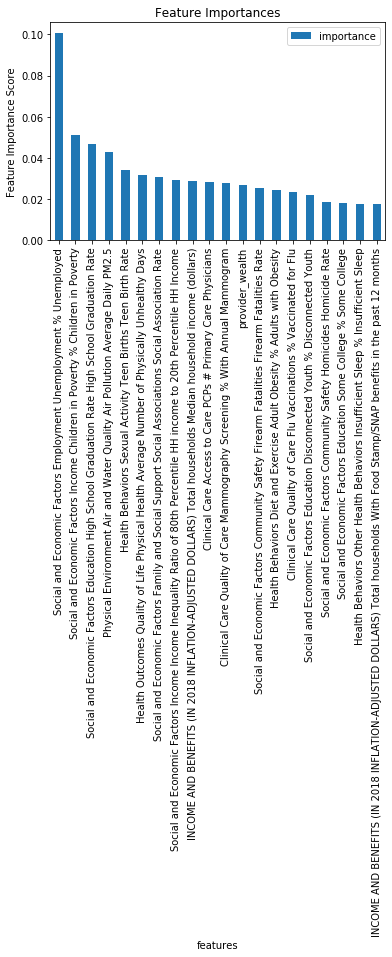

In [91]:
%%time
xgb6 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=50,
 n_jobs=8,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'reg:squarederror',
 eval_metric = 'auc',
 scale_pos_weight=6,
 max_delta_step=6,
 reg_alpha=1,
 seed=27)
modelfit_regression(xgb6, X_train, y_train, X_test, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=50)

In [92]:
feat_imp = pd.DataFrame({'features':features})
feat_imp['importance'] = xgb6.feature_importances_
feat_imp = feat_imp.sort_values(by = 'importance', ascending=False)

In [93]:
feat_imp

,features,importance
6,Social and Economic Factors Employment Unemplo...,0.100913
17,Social and Economic Factors Income Children in...,0.050794
50,Social and Economic Factors Education High Sch...,0.046826
49,Physical Environment Air and Water Quality Air...,0.042493
37,Health Behaviors Sexual Activity Teen Births T...,0.033955
9,Health Outcomes Quality of Life Physical Healt...,0.031548
10,Social and Economic Factors Family and Social ...,0.030601
14,Social and Economic Factors Income Income Ineq...,0.028895
29,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,0.028780
41,Clinical Care Access to Care PCPs # Primary Ca...,0.027929


In [94]:
explainerXGB = shap.TreeExplainer(xgb6)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [95]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [96]:
shap.initjs()

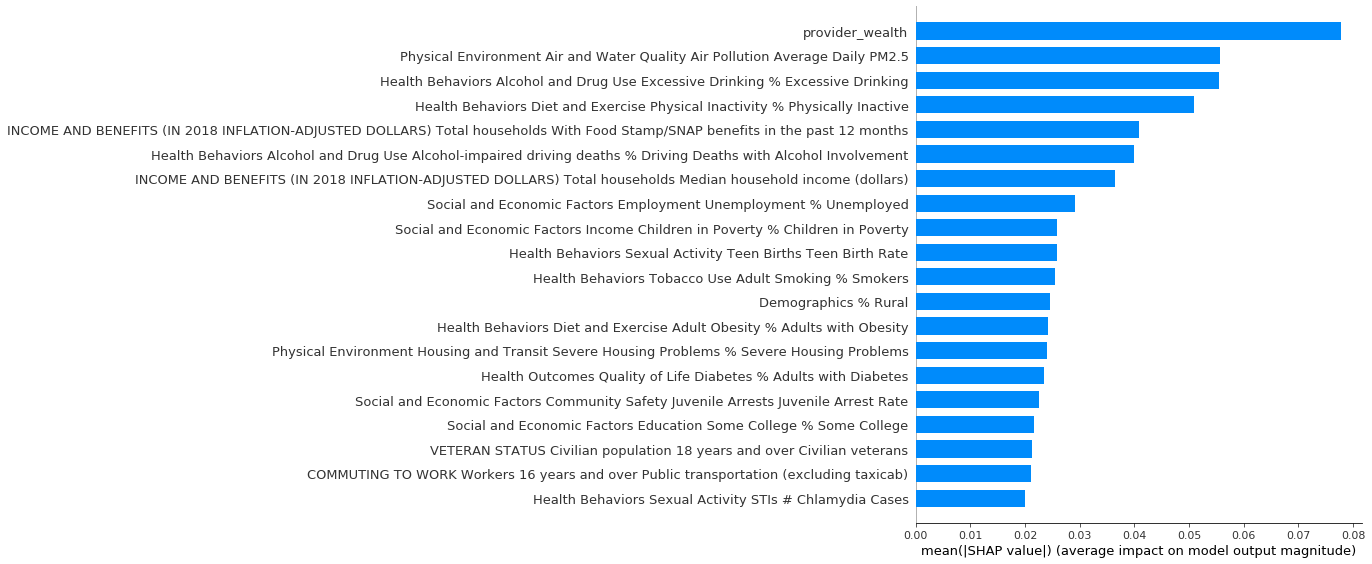

In [97]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

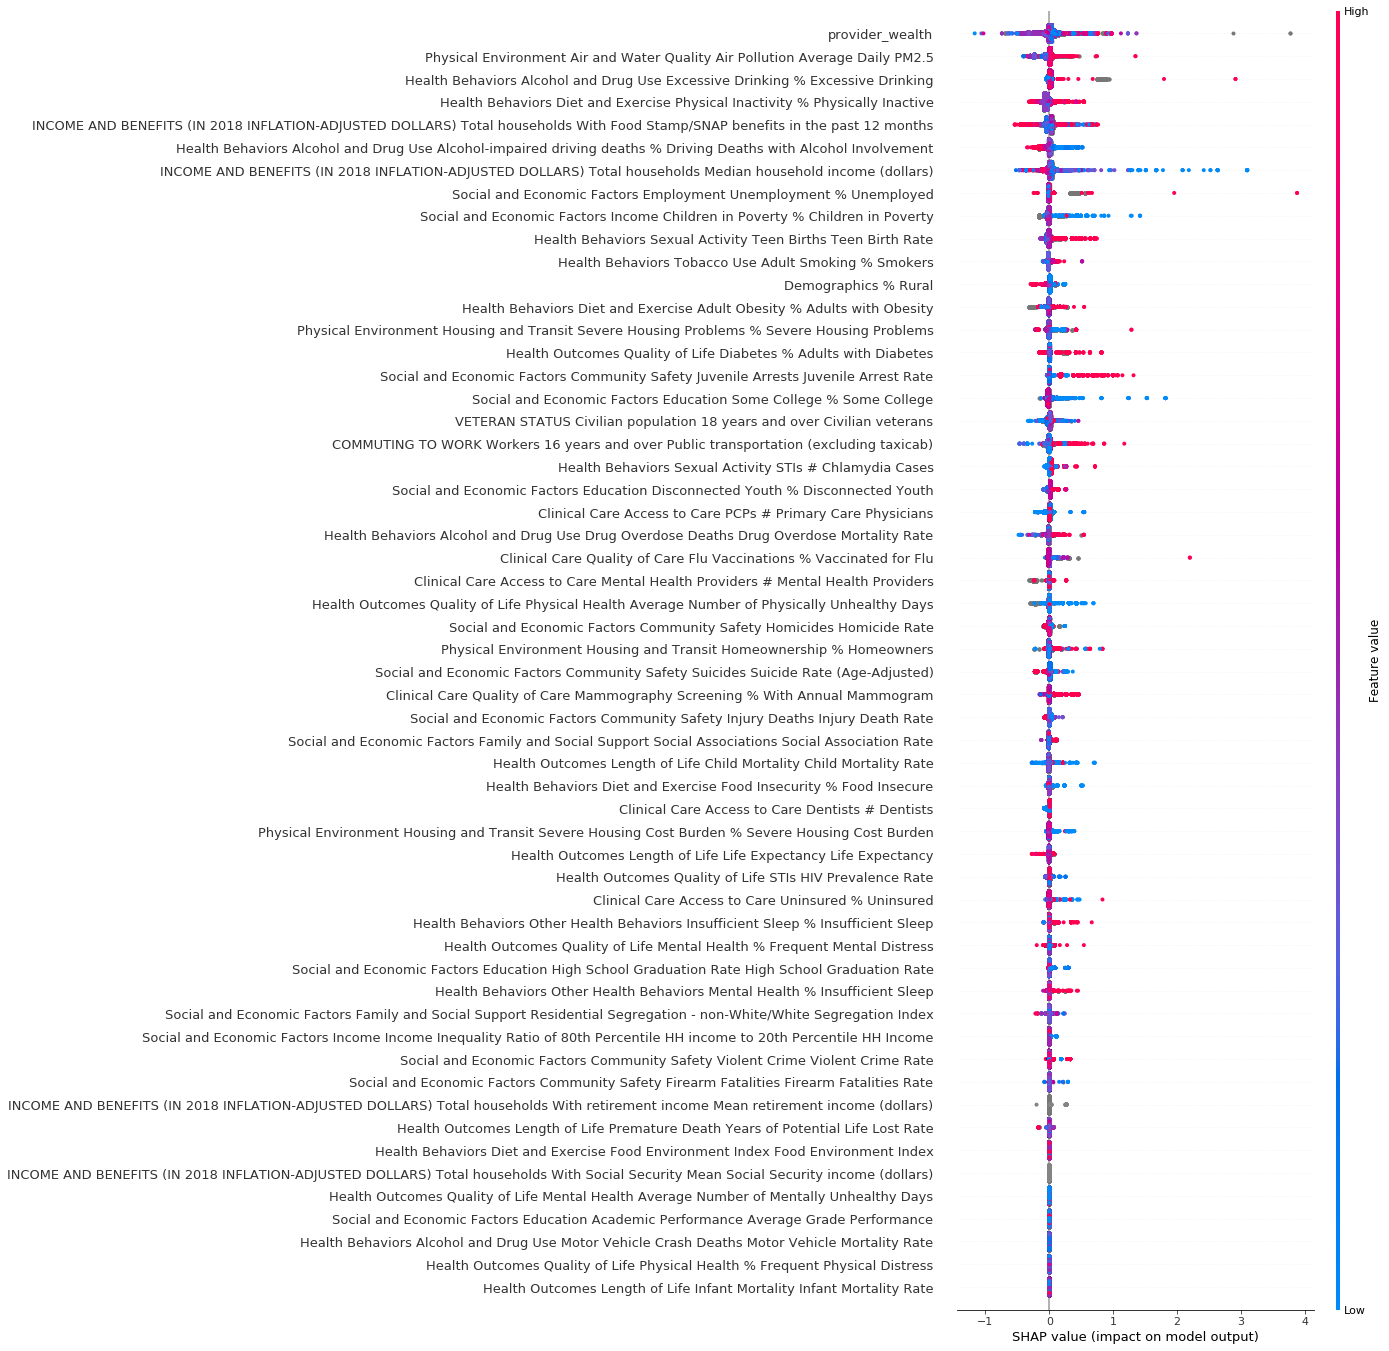

In [98]:
shap.summary_plot(shap_values_XGB_train, X_train, max_display=X_train.shape[1])

In [245]:
xgb6.get_booster().feature_names

['Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate',
 'Demographics % Rural',
 'Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate',
 'Social and Economic Factors Employment Unemployment % Unemployed',
 'Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep',
 'Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days',
 'Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months',
 'Social and Economic Factors Education Disconnected Youth % Disconnected Youth',
 'Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days',
 'Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive',
 'Social and Economic Factors Family and Social Support Social Associations Social Association Rate',
 'VETERAN STATUS Civilian population 18 years and over Civilian veterans',
 'Clinical Care Access to Care PCPs # Primary Care Physicians',
 'Social and Economic Factors Community Safety Violent Crime Violent Crime Rate',
 'Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)',
 'Clinical Care Access to Care Uninsured % Uninsured',
 'Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
 'Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate',
 'Health Behaviors Tobacco Use Adult Smoking % Smokers',
 'Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate',
 'Social and Economic Factors Education Academic Performance Average Grade Performance',
 'Health Behaviors Sexual Activity Teen Births Teen Birth Rate',
 'Social and Economic Factors Income Children in Poverty % Children in Poverty',
 'Social and Economic Factors Community Safety Injury Deaths Injury Death Rate',
 'Health Outcomes Quality of Life Physical Health % Frequent Physical Distress',
 'Social and Economic Factors Family and Social Support Residential Segregation - non-White/White Segregation Index',
 'Health Outcomes Quality of Life Diabetes % Adults with Diabetes',
 'Social and Economic Factors Education Some College % Some College',
 'Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate',
 'Clinical Care Access to Care Mental Health Providers # Mental Health Providers',
 'Social and Economic Factors Community Safety Homicides Homicide Rate',
 'Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity',
 'Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement',
 'Social and Economic Factors Education High School Graduation Rate High School Graduation Rate',
 'Health Outcomes Quality of Life Mental Health % Frequent Mental Distress',
 'Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income',
 'Health Outcomes Length of Life Infant Mortality Infant Mortality Rate',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars)',
 'Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars)',
 'Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5',
 'Health Behaviors Diet and Exercise Food Insecurity % Food Insecure',
 'Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems',
 'provider_wealth',
 'Health Outcomes Length of Life Life Expectancy Life Expectancy',
 'Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu',
 'Health Outcomes Length of Life Child Mortality Child Mortality Rate',
 'Healt

In [271]:
features = ['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
            'Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income',
            'Social and Economic Factors Family and Social Support Social Associations Social Association Rate',
            'Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)',
            'Clinical Care Quality of Care Mammography Screening % With Annual Mammogram',
            'provider_wealth',
            'Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement',
            'Social and Economic Factors Education High School Graduation Rate High School Graduation Rate',
            'Clinical Care Access to Care Uninsured % Uninsured']

In [272]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final[features], df_final['cc_count'], test_size=0.1,random_state=5)


Model Report
R2 0.006032932460148466
Mean Squared Error 96.96166204407085
Mean Absolute Error 2.770113601849391
R2 0.003273912235284726
Mean Squared Error 88.27637309111068
Mean Absolute Error 2.776688446918055
CPU times: user 9.13 s, sys: 9.14 ms, total: 9.14 s
Wall time: 1.4 s


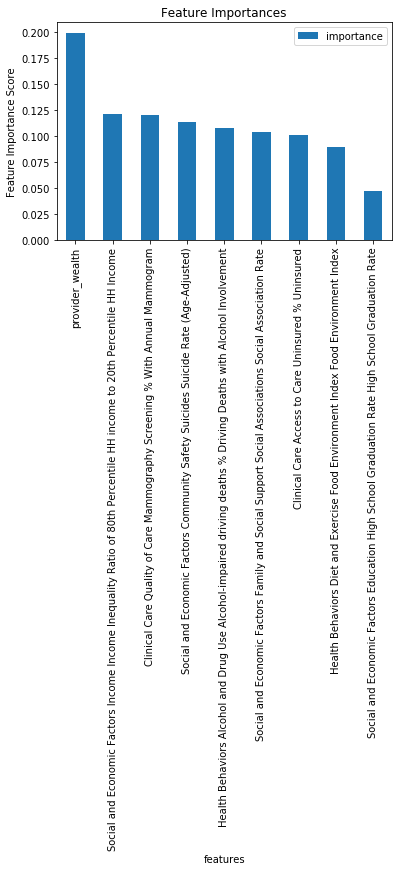

In [273]:
%%time
xgb7 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=50,
 n_jobs=8,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'reg:squarederror',
 eval_metric = 'auc',
 scale_pos_weight=6,
 max_delta_step=6,
 reg_alpha=1,
 seed=27)
modelfit_regression(xgb7, X_train, y_train, X_test, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=50)

In [274]:
feat_imp = pd.DataFrame({'features':features})
feat_imp['importance'] = xgb7.feature_importances_
feat_imp = feat_imp.sort_values(by = 'importance', ascending=False)

In [275]:
feat_imp

,features,importance
5,provider_wealth,0.199049
1,Social and Economic Factors Income Income Ineq...,0.120670
4,Clinical Care Quality of Care Mammography Scre...,0.120252
3,Social and Economic Factors Community Safety S...,0.112801
6,Health Behaviors Alcohol and Drug Use Alcohol-...,0.107237
2,Social and Economic Factors Family and Social ...,0.103975
8,Clinical Care Access to Care Uninsured % Unins...,0.100439
0,Health Behaviors Diet and Exercise Food Enviro...,0.088849
7,Social and Economic Factors Education High Sch...,0.046728


In [276]:
explainerXGB = shap.TreeExplainer(xgb7)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [277]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [278]:
shap.initjs()

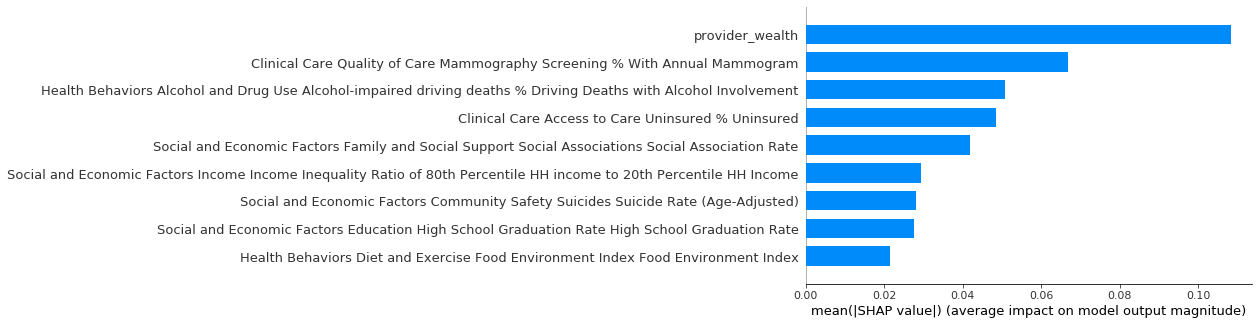

In [279]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

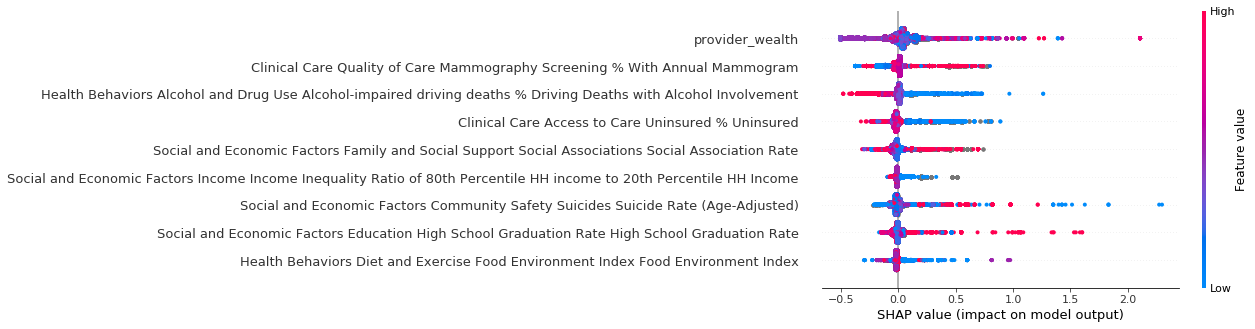

In [280]:
shap.summary_plot(shap_values_XGB_train, X_train, max_display=X_train.shape[1])

In [172]:
features = ['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
            'Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking',
            'Social and Economic Factors Community Safety Injury Deaths Injury Death Rate',
            'Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income',
            'Social and Economic Factors Family and Social Support Social Associations Social Association Rate',
            'Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)',
            'Social and Economic Factors Community Safety Violent Crime Violent Crime Rate', 
            'Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity',
            'Clinical Care Quality of Care Mammography Screening % With Annual Mammogram',
            'provider_wealth']

In [173]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final[features], df_final['cc_count'], test_size=0.1,random_state=5)


Model Report
R2 0.006598239231531466
Mean Squared Error 96.90651626921765
Mean Absolute Error 2.7691293026603887
R2 0.0023956883156261988
Mean Squared Error 88.35415416189933
Mean Absolute Error 2.7795202368569294
CPU times: user 8.64 s, sys: 3.45 ms, total: 8.64 s
Wall time: 1.31 s


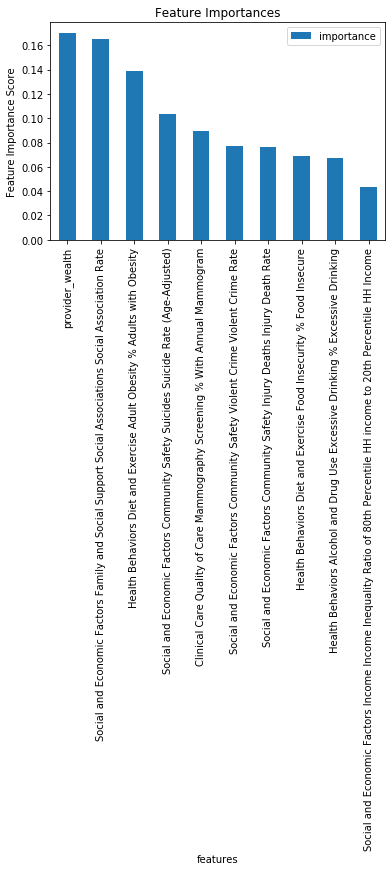

In [174]:
%%time
xgb8 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=50,
 n_jobs=8,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'reg:squarederror',
 eval_metric = 'auc',
 scale_pos_weight=6,
 max_delta_step=6,
 reg_alpha=1,
 seed=27)
modelfit_regression(xgb8, X_train, y_train, X_test, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=50)

In [175]:
feat_imp = pd.DataFrame({'features':features})
feat_imp['importance'] = xgb8.feature_importances_
feat_imp = feat_imp.sort_values(by = 'importance', ascending=False)

In [176]:
feat_imp

,features,importance
9,provider_wealth,0.170291
4,Social and Economic Factors Family and Social ...,0.164987
7,Health Behaviors Diet and Exercise Adult Obesi...,0.138674
5,Social and Economic Factors Community Safety S...,0.103378
8,Clinical Care Quality of Care Mammography Scre...,0.089261
6,Social and Economic Factors Community Safety V...,0.077463
2,Social and Economic Factors Community Safety I...,0.076483
0,Health Behaviors Diet and Exercise Food Insecu...,0.068706
1,Health Behaviors Alcohol and Drug Use Excessiv...,0.067263
3,Social and Economic Factors Income Income Ineq...,0.043493


In [177]:
explainerXGB = shap.TreeExplainer(xgb8)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [178]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [179]:
shap.initjs()

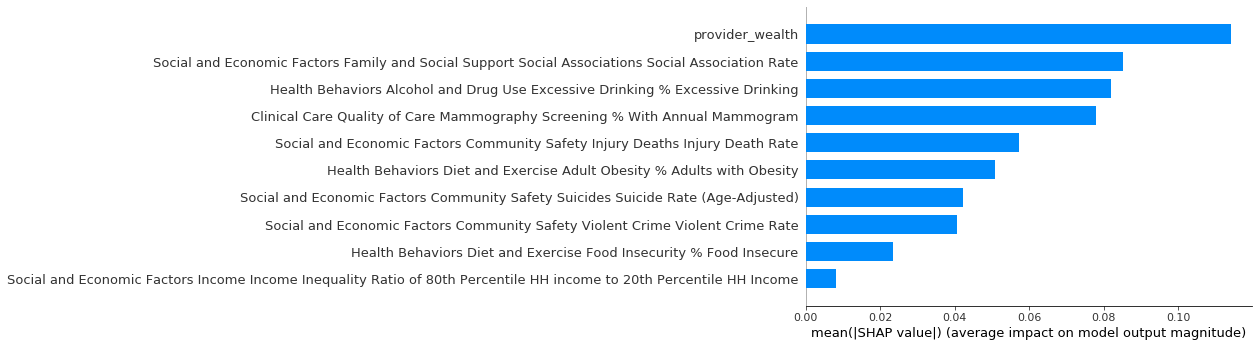

In [180]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

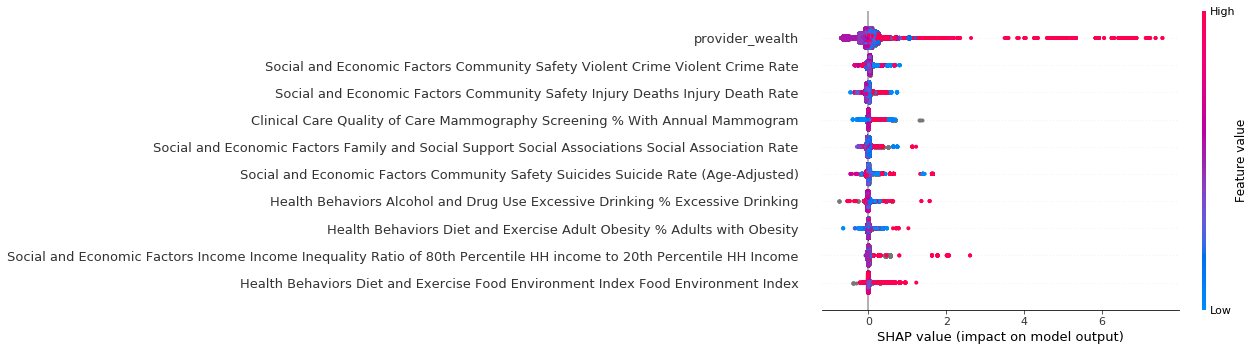

In [265]:
shap.summary_plot(shap_values_XGB_train, X_train, max_display=X_train.shape[1])

In [28]:
features = ['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
            'Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking',
            'Social and Economic Factors Community Safety Injury Deaths Injury Death Rate',
            'Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income',
            'Social and Economic Factors Family and Social Support Social Associations Social Association Rate',
            'Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)',
            'Social and Economic Factors Community Safety Violent Crime Violent Crime Rate', 
            'Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity',
            'Clinical Care Quality of Care Mammography Screening % With Annual Mammogram']

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final[features], df_final['cc_count'], test_size=0.1,random_state=5)


Model Report
R2 0.002133618145385374
Mean Squared Error 78.97792020573048
Mean Absolute Error 2.5826338808493188
R2 0.0018987432044785812
Mean Squared Error 70.48324885630223
Mean Absolute Error 2.536296676422938
CPU times: user 24.7 s, sys: 66.6 ms, total: 24.8 s
Wall time: 4.7 s


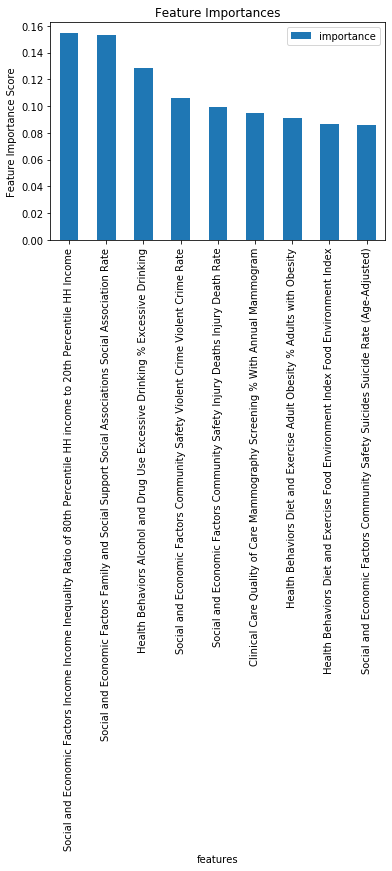

In [30]:
%%time
xgb9 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=50,
 n_jobs=8,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'reg:squarederror',
 eval_metric = 'auc',
 scale_pos_weight=6,
 max_delta_step=6,
 reg_alpha=1,
 seed=27)
modelfit_regression(xgb9, X_train, y_train, X_test, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=50)

In [31]:
feat_imp = pd.DataFrame({'features':features})
feat_imp['importance'] = xgb9.feature_importances_
feat_imp = feat_imp.sort_values(by = 'importance', ascending=False)

In [32]:
feat_imp

,features,importance
3,Social and Economic Factors Income Income Ineq...,0.154827
4,Social and Economic Factors Family and Social ...,0.152809
1,Health Behaviors Alcohol and Drug Use Excessiv...,0.128110
6,Social and Economic Factors Community Safety V...,0.106388
2,Social and Economic Factors Community Safety I...,0.099596
8,Clinical Care Quality of Care Mammography Scre...,0.094578
7,Health Behaviors Diet and Exercise Adult Obesi...,0.090865
0,Health Behaviors Diet and Exercise Food Enviro...,0.086639
5,Social and Economic Factors Community Safety S...,0.086188


In [35]:
explainerXGB = shap.TreeExplainer(xgb9)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [36]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

In [1]:
shap.initjs()

NameError: name 'shap' is not defined

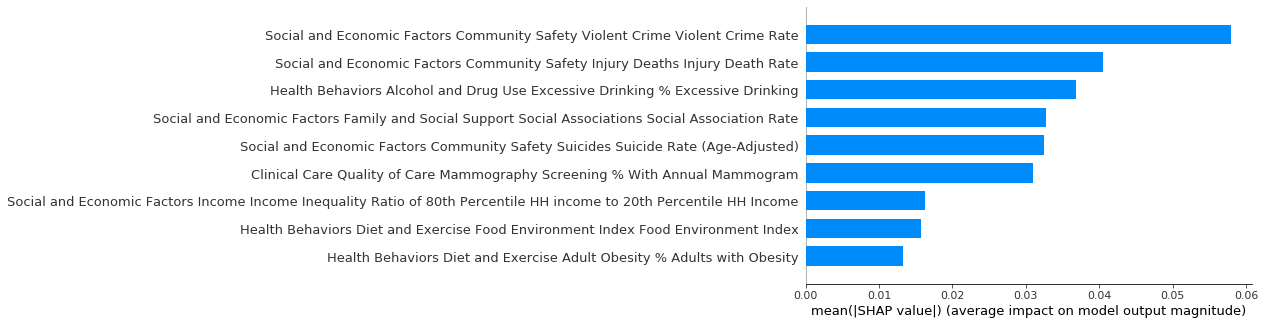

In [38]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

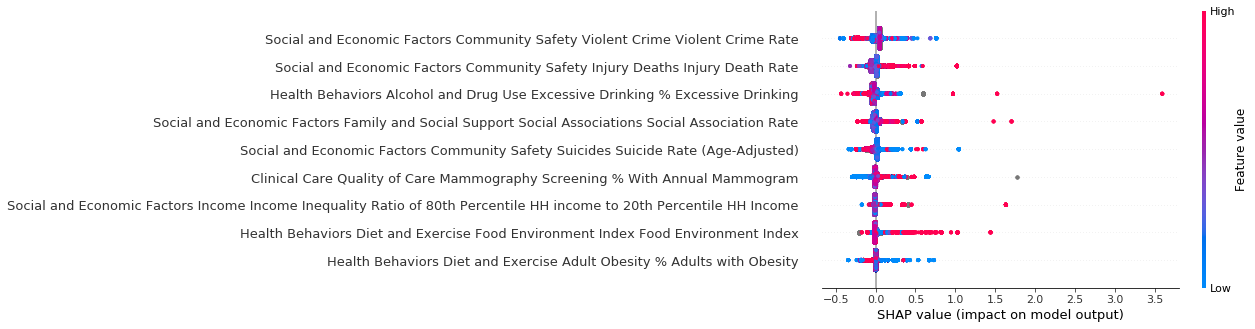

In [39]:
shap.summary_plot(shap_values_XGB_train, X_train, max_display=X_train.shape[1])

In [ ]:
##find everyone's percentile for the 9 chosen fields
##calculate average percentile over them all
##translate percentile into scale from -5 to 5 or something

In [281]:
df_final['sdoh_1']=df_final['Social and Economic Factors Education High School Graduation Rate High School Graduation Rate'].rank(pct=True)*-1
df_final['sdoh_2']=df_final['Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement'].rank(pct=True)
df_final['sdoh_3']=df_final['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].rank(pct=True)
df_final['sdoh_4']=df_final['Clinical Care Access to Care Uninsured % Uninsured'].rank(pct=True)
df_final['sdoh_5']=df_final['Social and Economic Factors Family and Social Support Social Associations Social Association Rate'].rank(pct=True)*-1
df_final['sdoh_6']=df_final['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].rank(pct=True)*-1
df_final['sdoh_7']=df_final['Clinical Care Quality of Care Mammography Screening % With Annual Mammogram'].rank(pct=True)*-1
df_final['sdoh_8']=df_final['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].rank(pct=True)
df_final['sdoh_9']=df_final['provider_wealth'].rank(pct=True)*-1

In [282]:
df_final['sdoh_avg'] = df_final[['sdoh_1','sdoh_2','sdoh_3','sdoh_4','sdoh_5','sdoh_6','sdoh_7','sdoh_8','sdoh_9']].mean(axis=1)

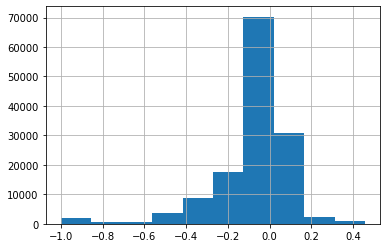

In [283]:
df_final['sdoh_avg'].hist()

In [286]:
df_final['sdoh_final']=(df_final['sdoh_avg']*10)

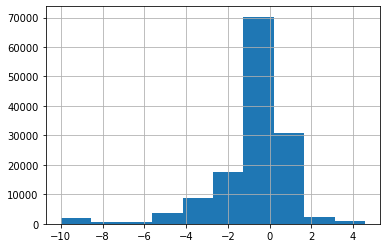

In [287]:
df_final['sdoh_final'].hist()

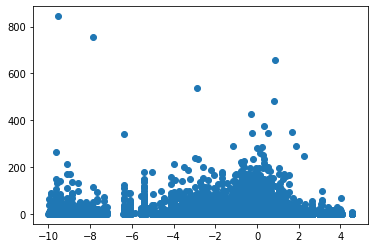

In [288]:
plt.scatter(df_final['sdoh_final'], df_final['cc_count'])

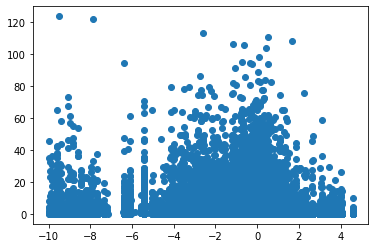

In [289]:
plt.scatter(df_final['sdoh_final'], df_final['risk_score'])

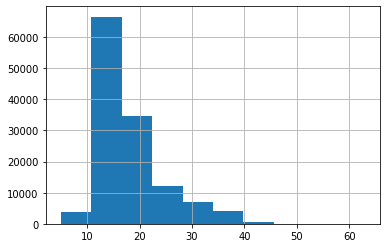

In [290]:
df_final['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].hist()

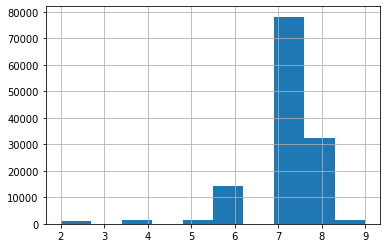

In [291]:
df_final['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].hist()

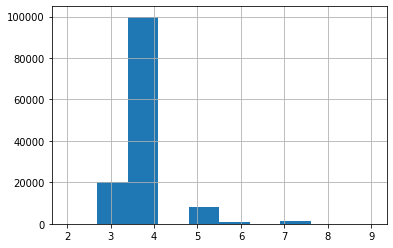

In [292]:
df_final['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].hist()

In [293]:
df_final.sort_values('sdoh_final',ascending=True).head(20)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Socia

In [294]:
df_final['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].isna().sum()

7317

In [295]:
df_final['Social and Economic Factors Community Safety Violent Crime Violent Crime Rate'].isna().sum()

7373

In [296]:
df_final['Social and Economic Factors Community Safety Injury Deaths Injury Death Rate'].isna().sum()

7369

In [297]:
df_final['Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking'].isna().sum()

7316

In [298]:
df_final['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].isna().sum()

9045

In [299]:
df_final['Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity'].isna().sum()

7316

In [300]:
df_final['Clinical Care Quality of Care Mammography Screening % With Annual Mammogram'].isna().sum()

7316

In [301]:
df_final['Social and Economic Factors Family and Social Support Social Associations Social Association Rate'].isna().sum()

7316

In [302]:
df_final['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].isna().sum()

7316

In [303]:
df_final_impute = df_final

In [304]:
for column in features:
    df_final_impute[column].fillna(df_final_impute[column].mean(), inplace=True)

In [305]:
df_final_impute['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].isna().sum()

0

In [306]:
df_final_impute['sdoh_1']=df_final_impute['Social and Economic Factors Education High School Graduation Rate High School Graduation Rate'].rank(pct=True)*-1
df_final_impute['sdoh_2']=df_final_impute['Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement'].rank(pct=True)
df_final_impute['sdoh_3']=df_final_impute['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].rank(pct=True)
df_final_impute['sdoh_4']=df_final_impute['Clinical Care Access to Care Uninsured % Uninsured'].rank(pct=True)
df_final_impute['sdoh_5']=df_final_impute['Social and Economic Factors Family and Social Support Social Associations Social Association Rate'].rank(pct=True)*-1
df_final_impute['sdoh_6']=df_final_impute['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].rank(pct=True)*-1
df_final_impute['sdoh_7']=df_final_impute['Clinical Care Quality of Care Mammography Screening % With Annual Mammogram'].rank(pct=True)*-1
df_final_impute['sdoh_8']=df_final_impute['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].rank(pct=True)
df_final_impute['sdoh_9']=df_final_impute['provider_wealth'].rank(pct=True)*-1

In [307]:
df_final_impute['sdoh_avg'] = df_final_impute[['sdoh_1','sdoh_2','sdoh_3','sdoh_4','sdoh_5','sdoh_6','sdoh_7','sdoh_8','sdoh_9']].mean(axis=1)

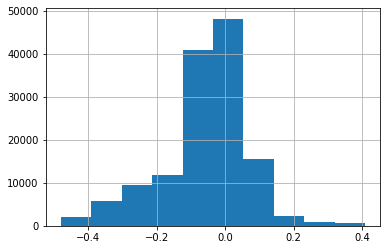

In [308]:
df_final_impute['sdoh_avg'].hist()

In [309]:
df_final_impute['sdoh_final']=(df_final_impute['sdoh_avg']*10)

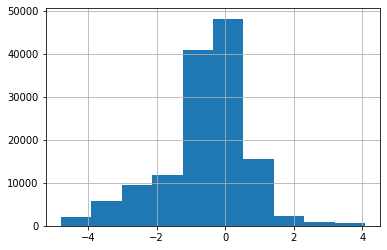

In [310]:
df_final_impute['sdoh_final'].hist()

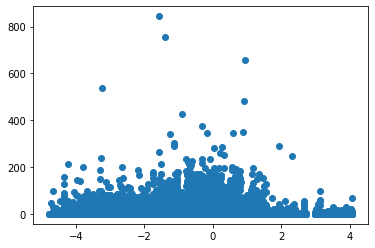

In [311]:
plt.scatter(df_final_impute['sdoh_final'], df_final_impute['cc_count'])

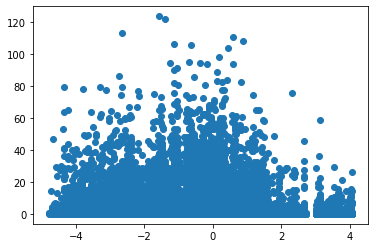

In [312]:
plt.scatter(df_final_impute['sdoh_final'], df_final_impute['risk_score'])

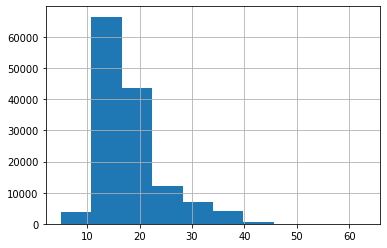

In [313]:
df_final_impute['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].hist()

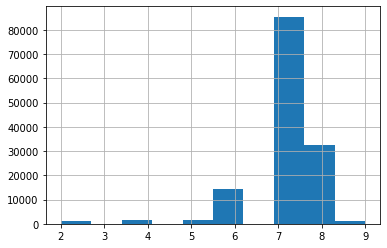

In [314]:
df_final_impute['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].hist()

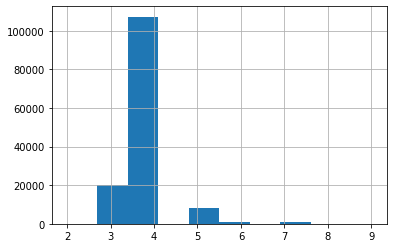

In [315]:
df_final_impute['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].hist()

In [316]:
df_final_impute.sort_values('sdoh_final',ascending=True).head(5)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Socia

In [317]:
df_final_impute.sort_values('sdoh_final',ascending=False).head(5)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Socia